In [126]:
import yfinance as yf
import numpy as np
import pandas as pd
import arch
import matplotlib.pyplot as plt

In [127]:
ticker = "^GSPC"
data = yf.download(ticker, start="1960-01-01", end="2023-01-01")

C:\Users\jdobe\AppData\Local\Temp\ipykernel_3812\2793084089.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="1960-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


In [128]:
print(data.head())
print(data.shape)

Price           Close       High        Low       Open   Volume
Ticker          ^GSPC      ^GSPC      ^GSPC      ^GSPC    ^GSPC
Date                                                           
1960-01-04  59.910000  59.910000  59.910000  59.910000  3990000
1960-01-05  60.389999  60.389999  60.389999  60.389999  3710000
1960-01-06  60.130001  60.130001  60.130001  60.130001  3730000
1960-01-07  59.689999  59.689999  59.689999  59.689999  3310000
1960-01-08  59.500000  59.500000  59.500000  59.500000  3290000
(15858, 5)


In [129]:
# Create variable Log Returns and further
data["DailyReturn"] = np.log(data["Close"]).diff()
data['Sign_1d'] = (data['DailyReturn'] > 0).astype(int)
data = data.iloc[1:]

In [130]:
model = arch.arch_model(data["DailyReturn"]*1000, vol="GARCH", p=1, q=1)
model_fit = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 923796090312.3402
Iteration:      2,   Func. Count:     14,   Neg. LLF: 12188402.664294241
Iteration:      3,   Func. Count:     21,   Neg. LLF: 56316.15451782483
Iteration:      4,   Func. Count:     27,   Neg. LLF: 56192.376620714
Iteration:      5,   Func. Count:     33,   Neg. LLF: 5583550820.0031395
Iteration:      6,   Func. Count:     39,   Neg. LLF: 56370.391117195555
Iteration:      7,   Func. Count:     45,   Neg. LLF: 56169.7555719136
Iteration:      8,   Func. Count:     51,   Neg. LLF: 56178.99098546479
Iteration:      9,   Func. Count:     57,   Neg. LLF: 56157.648427601016
Iteration:     10,   Func. Count:     62,   Neg. LLF: 56157.628385307726
Iteration:     11,   Func. Count:     67,   Neg. LLF: 56157.628269854904
Iteration:     12,   Func. Count:     72,   Neg. LLF: 56157.628261777616
Iteration:     13,   Func. Count:     76,   Neg. LLF: 56157.62826177861
Optimization terminated successfully    (Exit mode 0)
      

In [131]:
data['GARCH_volatility'] = model_fit.conditional_volatility
data['inv_vol'] = 1 / data['GARCH_volatility']
data.head()

Price,Close,High,Low,Open,Volume,DailyReturn,Sign_1d,GARCH_volatility,inv_vol
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,,,,
Date,,,,,,,,,
1960-01-05,60.389999,60.389999,60.389999,60.389999,3710000,0.007980,1,7.376043,0.135574
1960-01-06,60.130001,60.130001,60.130001,60.130001,3730000,-0.004315,0,7.429550,0.134598
1960-01-07,59.689999,59.689999,59.689999,59.689999,3310000,-0.007344,0,7.262138,0.137701
1960-01-08,59.500000,59.500000,59.500000,59.500000,3290000,-0.003188,0,7.365763,0.135763
1960-01-11,58.770000,58.770000,58.770000,58.770000,3470000,-0.012345,0,7.138952,0.140077


In [132]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.preprocessing import StandardScaler

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

The window size is actually quite important, because it determines how many lags should be considered. There was a paper that suggested to not use more than 48 time steps for a LSTM.

In [133]:
window_size = 20  # number of lagged observations
train_size = 5000
data = data.copy()

# Add lagged returns as features
data['Lag1'] = data['DailyReturn'].shift(1)
data['Lag2'] = data['DailyReturn'].shift(2)
data['Lag3'] = data['DailyReturn'].shift(3)

data = data.dropna()

# Feature matrix: inv_vol + lagged returns
features = np.column_stack([
    data['inv_vol'].values,
    data['Lag1'].values,
    data['Lag2'].values,
    data['Lag3'].values
])

input_variables = features.shape[1]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

Currently, the past returns and inverse volatility are used for predicting the next retun. This might not be economically sensible as many people believe returns are independent and form a martingale difference sequence (MDS). 

In [134]:
features

array([[ 0.13576325, -0.00734442, -0.00431462,  0.00798008],
       [ 0.14007658, -0.00318817, -0.00734442, -0.00431462],
       [ 0.1262952 , -0.01234478, -0.00318817, -0.00734442],
       ...,
       [ 0.08300873, -0.00405784,  0.00585095, -0.01455714],
       [ 0.08264597, -0.01209347, -0.00405784,  0.00585095],
       [ 0.07916848,  0.01731063, -0.01209347, -0.00405784]],
      shape=(15854, 4))

By using StandardScaler, each variable will be standard normally distributed.

In [135]:
# Create lagged feature matrix for LSTM
def create_lagged_matrix_multifeature(X, window):
    out = []
    for i in range(window, len(X)):
        out.append(X[i-window:i, :])
    return np.array(out)

X_lagged = create_lagged_matrix_multifeature(features_scaled, window_size)
y_target = data['Sign_1d'].values[window_size:]

In [136]:
# Split train/test
X_train = X_lagged[:train_size]
y_train = y_target[:train_size]
X_test = X_lagged[train_size:]
y_test = y_target[train_size:]

# Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)

## Define LSTM Model

In [137]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return self.sigmoid(out)

model = SimpleLSTM(input_dim=input_variables, hidden_dim=64)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [138]:
model.train()
for epoch in range(10):
    optimizer.zero_grad()
    y_pred = model(X_train_t)
    loss = criterion(y_pred, y_train_t)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}: loss = {loss.item():.4f}")

# --- Predict out-of-sample ---
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_t).squeeze().numpy()
    y_pred_sign = (y_pred_test > 0.5).astype(int)

# --- Results ---
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_sign,
    'Probability': y_pred_test
}, index=data.index[window_size+train_size:])

Epoch 1: loss = 0.6948
Epoch 2: loss = 0.6942
Epoch 3: loss = 0.6936
Epoch 4: loss = 0.6931
Epoch 5: loss = 0.6927
Epoch 6: loss = 0.6923
Epoch 7: loss = 0.6921
Epoch 8: loss = 0.6918
Epoch 9: loss = 0.6917
Epoch 10: loss = 0.6916


In [139]:
from sklearn.metrics import classification_report, accuracy_score

# Classification report
print("Classification Report:")
print(classification_report(results['Actual'], results['Predicted']))
print("Accuracy:", accuracy_score(results['Actual'], results['Predicted']))

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.15      0.23      5063
           1       0.53      0.85      0.65      5771

    accuracy                           0.52     10834
   macro avg       0.50      0.50      0.44     10834
weighted avg       0.50      0.52      0.46     10834

Accuracy: 0.5227985970094148


<Axes: xlabel='Date'>

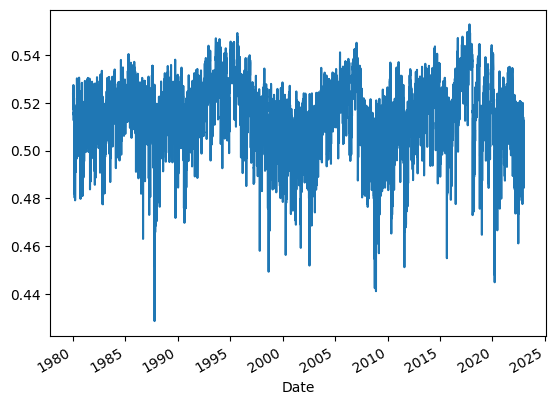

In [140]:
results["Probability"].plot()